In [2]:
import json
from matplotlib import pyplot as plt
import numpy as np

RESULT_FOLDER = "./results"
SEED = 46

llms = ["gemma2_9b", "llama3.1_8b", "llama3.2_3b", "mistral_7b", "qwen2.5_7b", "qwen3_4b"]
rms = ["fsfairx_rm", "mistral_rm"]

llm_name = llms[0]
rm_name = rms[0]


llm_mapping = {
    "gemma2_9b": "google/gemma-2-9b-it", 
    "llama3.1_8b": "meta-llama/Llama-3.1-8B-Instruct",
    "llama3.2_3b": "meta-llama/Llama-3.2-3B-Instruct",
    "mistral_7b": "mistralai/Mistral-7B-Instruct-v0.3",
    "qwen2.5_7b": "Qwen/Qwen2.5-7B-Instruct",
    "qwen3_4b": "Qwen/Qwen3-4B-Instruct-2507",
}

rm_mapping = {
    "fsfairx_rm": "sfairXC/FsfairX-LLaMA3-RM-v0.1", 
    "mistral_rm": "weqweasdas/RM-Mistral-7B"
}

In [3]:
def read_cost_analysis(llm_name, rm_name):
    data = []
    file_name = f"{RESULT_FOLDER}/target_wr_{llm_name}_{rm_name}_{SEED}.jsonl"
    lines = []
    with open(file_name, "r") as f:
        lines = f.readlines()

    for line in lines:
        data.append(json.loads(line))

    return data

In [4]:
def get_save_ratios(data):
    data_points = {}
    for i in range(len(data)):
        scores = [[] for i in range(len(data[i]["na"][0]["scores"]))]
        for j in range(len(data[i]["na"])):
            for l, x in enumerate(data[i]["na"][j]["scores"]):
                scores[l].append(x)
        max_scores = [s[-1] for s in scores]
        win_rates = [ 
            np.mean(
                [  
                    np.exp(scores[l][j])/(np.exp(scores[l][j]) + np.exp(max_scores[l])) 
                    for l in range(len(data[i]["na"][j]["scores"])) 
                ]
            ) 
            for j in range(len(data[i]["na"]))
        ]
    
        As = data[i]["a"]
        
        for item in As:
            target_wr = item["target_wr"]
            mean_wr = item["mean"]
            for j in range(len(win_rates)):
                if win_rates[j] > mean_wr:
                    break
            adaptive_sample_count = item["sample_count"]
            nonadaptive_sample_count = j
            save_ratio = (nonadaptive_sample_count - adaptive_sample_count)/nonadaptive_sample_count
    
            if target_wr not in data_points:
                data_points[target_wr] = []
    
            data_points[target_wr].append({
                "adaptive_sample_count": adaptive_sample_count,
                "nonadaptive_sample_count": nonadaptive_sample_count,
                "save_ratio": save_ratio
            })
    return data_points

In [5]:
def get_mean_win_rate(data):
    data_points = {}
    for i in range(len(data)):
        for item in data[i]["a"]:
            target_wr = item["target_wr"]
            if target_wr not in data_points:
                data_points[target_wr] = []

            data_points[target_wr].append(item["mean"])
    return data_points

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def create_comparison_plots_multi(save_ratio_data_dict, win_rate_data_dict, figsize=(16, 6), figure_title=""):
    """
    Create side-by-side comparison plots with multiple datasets.
    
    Parameters
    ----------
    save_ratio_data_dict : dict
        Dictionary where keys are dataset names and values are save ratio data dicts
    win_rate_data_dict : dict
        Dictionary where keys are dataset names and values are win rate data dicts
    figsize : tuple
        Figure size for combined plot
    
    Returns
    -------
    fig, axes : matplotlib figure and axes objects
    """
    labels = []
    for k in save_ratio_data_dict.keys():
        labels.append(llm_mapping[k])
    
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    def plot_multi_medians(ax, data_dict, metric_key=None, ylabel='', 
                          add_diagonal=False, y_factor=1):
        """Helper function to plot medians for multiple datasets."""
        
        dataset_names = list(data_dict.keys())
        
        for idx, dataset_name in enumerate(dataset_names):
            data = data_dict[dataset_name]
            x_values = sorted(data.keys())
            
            # Calculate median values
            medians = []
            updated_x_values = []
            for x in x_values:
                if metric_key and isinstance(data[x][0], dict):
                    values = [item[metric_key] for item in data[x]]
                else:
                    values = data[x]
                medians.append(y_factor*np.median(values))
                updated_x_values.append(2*x)
            
            # Plot median line
            ax.plot(updated_x_values, medians, 's-', linewidth=2, markersize=6, 
                   label=labels[idx])
        
        # Add diagonal reference line if requested
        if add_diagonal:
            all_x_vals = []
            for data in data_dict.values():
                all_x_vals.extend(data.keys())
            lims = [min(all_x_vals), max(all_x_vals)]
            ax.plot([x*2 for x in lims], [x*2 for x in lims], 'k--', alpha=0.3, linewidth=1, 
                   label='y=x (Perfect Match)')
        
        # Styling
        ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
        ax.set_xlabel('Target Acceptance Rate', fontsize=14)
        ax.set_ylabel(ylabel, fontsize=14)
        ax.legend(loc='best', framealpha=0.9, fontsize=12)
        ax.set_facecolor('#f8f8f8')
    
    # Plot 1: Save Ratio (multiple medians)
    plot_multi_medians(axes[0], save_ratio_data_dict, metric_key='save_ratio',
                      ylabel='Save Ratio')
    axes[0].set_title('Target Acceptance Rate vs Save Ratio', fontsize=14)
    
    # Plot 2: Actual Win Rate (multiple medians)
    plot_multi_medians(axes[1], win_rate_data_dict, ylabel='Actual Acceptance Rate',
                      add_diagonal=True, y_factor=2)
    axes[1].set_title('Target Acceptance Rate vs Actual Acceptance Rate', fontsize=14)
    
    # Overall title
    fig.suptitle(figure_title, fontsize=16, y=0.99, fontweight='bold')
    fig.patch.set_facecolor('white')
    plt.tight_layout()
    
    return fig, axes


gemma2_9b
llama3.1_8b
mistral_7b
qwen2.5_7b


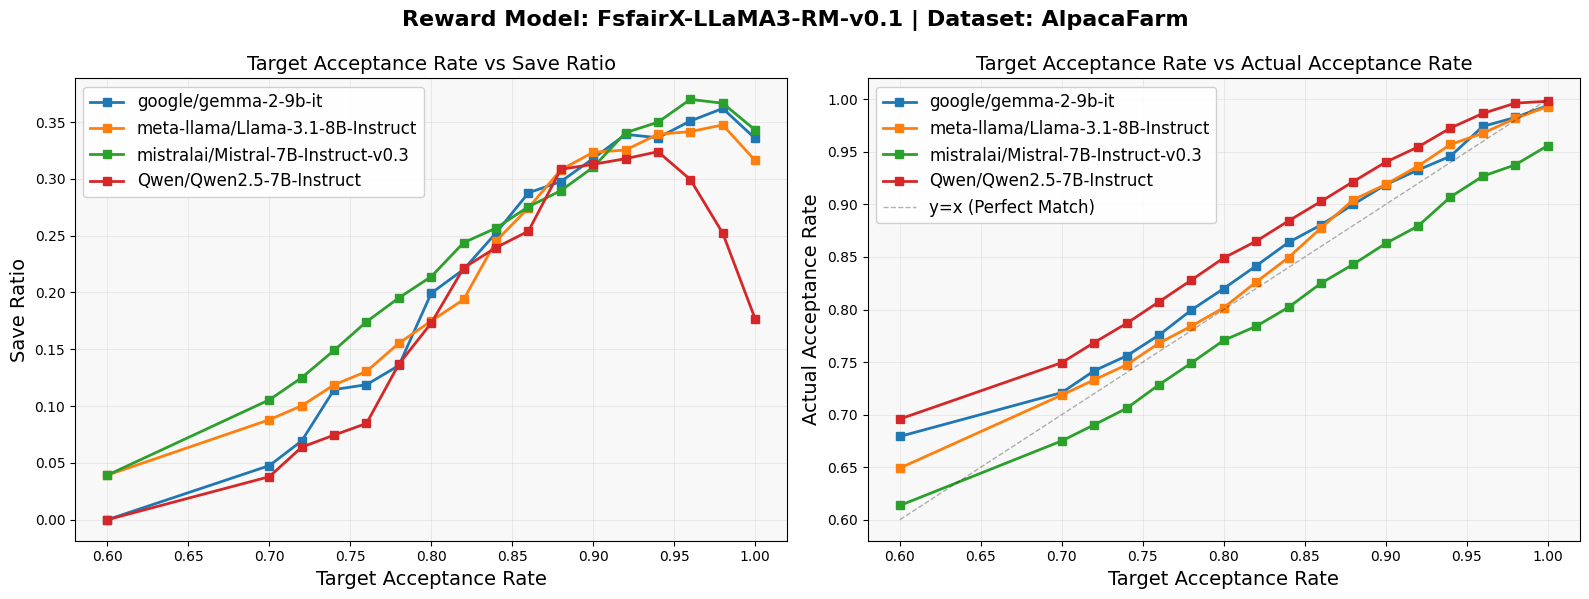

In [7]:
RESULT_FOLDER = "./results"

save_ratio_data_dict = {}
win_rate_data_dict = {}

llm_shortlist = [llms[0], llms[1], llms[3], llms[4]]

for lm in llm_shortlist:
    print(lm, flush=True)
    data = read_cost_analysis(lm, rms[0])
    save_ratio_data = get_save_ratios(data)
    mean_wr_data = get_mean_win_rate(data)
    save_ratio_data_dict[lm] = save_ratio_data
    win_rate_data_dict[lm] = mean_wr_data
fig, axes = create_comparison_plots_multi(save_ratio_data_dict, win_rate_data_dict, figure_title="Reward Model: FsfairX-LLaMA3-RM-v0.1 | Dataset: AlpacaFarm")
plt.show()

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'llm_mapping' is defined elsewhere in your code.
# Example: llm_mapping = {"key1": "Label 1", "key2": "Label 2"}

def create_comparison_plots_multi_with_percentiles(save_ratio_data_dict, win_rate_data_dict, figsize=(16, 6), figure_title=""):
    """
    Create side-by-side comparison plots with multiple datasets.
    
    Parameters
    ----------
    save_ratio_data_dict : dict
        Dictionary where keys are dataset names and values are save ratio data dicts
    win_rate_data_dict : dict
        Dictionary where keys are dataset names and values are win rate data dicts
    figsize : tuple
        Figure size for combined plot
    
    Returns
    -------
    fig, axes : matplotlib figure and axes objects
    """
    labels = []
    for k in save_ratio_data_dict.keys():
        # Use .get for safety, falling back to the key itself
        labels.append(llm_mapping.get(k, k)) 
    
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    def plot_multi_medians(ax, data_dict, metric_key=None, ylabel='', 
                           add_diagonal=False, y_factor=1):
        """Helper function to plot medians (line) and 25-75 percentile (band)."""
        
        dataset_names = list(data_dict.keys())
        
        for idx, dataset_name in enumerate(dataset_names):
            data = data_dict[dataset_name]
            x_values = sorted(data.keys())
            
            # Calculate stats
            medians = []
            q25s = []  # <-- ADDED
            q75s = []  # <-- ADDED
            updated_x_values = []
            
            for x in x_values:
                if metric_key and isinstance(data[x][0], dict):
                    values = [item[metric_key] for item in data[x]]
                else:
                    values = data[x]
                
                # Calculate and store all stats
                medians.append(y_factor * np.median(values))
                q25s.append(y_factor * np.percentile(values, 25))  # <-- ADDED
                q75s.append(y_factor * np.percentile(values, 75))  # <-- ADDED
                updated_x_values.append(2 * x)
            
            # Plot median line
            line = ax.plot(updated_x_values, medians, 's-', linewidth=2, markersize=6, 
                           label=labels[idx])
            
            # --- START: ADDED SHADED AREA ---
            # Get the color of the line that was just plotted
            color = line[0].get_color()
            
            # Add the shaded percentile area (25th to 75th)
            ax.fill_between(updated_x_values, 
                            q25s, 
                            q75s, 
                            color=color, 
                            alpha=0.2,      # Set transparency
                            interpolate=True)
            # --- END: ADDED SHADED AREA ---
            
        # Add diagonal reference line if requested
        if add_diagonal:
            all_x_vals = []
            for data in data_dict.values():
                all_x_vals.extend(data.keys())
            if all_x_vals: # Ensure list is not empty
                lims = [min(all_x_vals), max(all_x_vals)]
                ax.plot([x * 2 for x in lims], [x * 2 for x in lims], 'k--', alpha=0.3, linewidth=1, 
                        label='y=x (Perfect Match)')
        
        # Styling
        ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
        ax.set_xlabel('Target Acceptance Rate', fontsize=14)
        ax.set_ylabel(ylabel, fontsize=14)
        ax.legend(loc='best', framealpha=0.9, fontsize=12)
        ax.set_facecolor('#f8f8f8')
    
    # Plot 1: Save Ratio (multiple medians)
    plot_multi_medians(axes[0], save_ratio_data_dict, metric_key='save_ratio',
                       ylabel='Save Ratio')
    axes[0].set_title('Target Acceptance Rate vs Save Ratio', fontsize=14)
    
    # Plot 2: Actual Win Rate (multiple medians)
    plot_multi_medians(axes[1], win_rate_data_dict, ylabel='Actual Acceptance Rate',
                       add_diagonal=True, y_factor=2)
    axes[1].set_title('Target Acceptance Rate vs Actual Acceptance Rate', fontsize=14)
    
    # Overall title
    fig.suptitle(figure_title, fontsize=16, y=0.99, fontweight='bold')
    fig.patch.set_facecolor('white')
    plt.tight_layout()
    
    return fig, axes

gemma2_9b
llama3.1_8b
mistral_7b
qwen2.5_7b


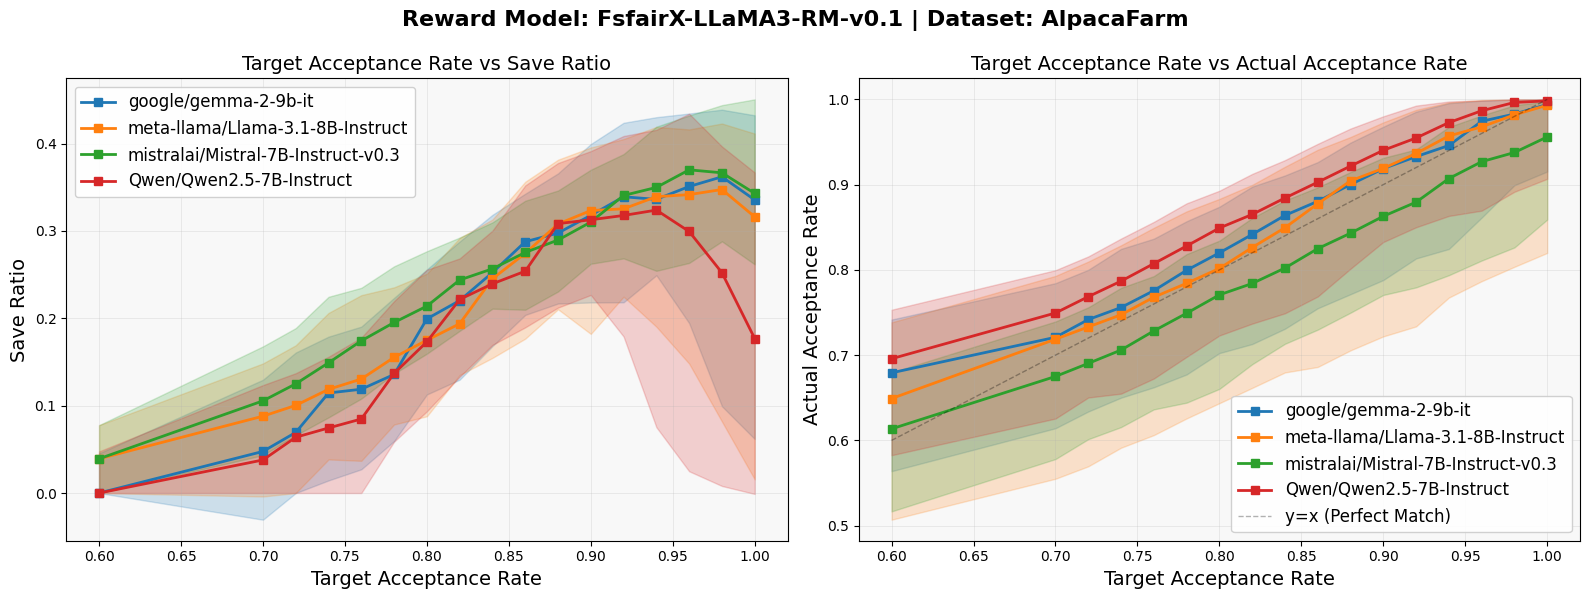

In [9]:
RESULT_FOLDER = "./results"

save_ratio_data_dict = {}
win_rate_data_dict = {}

llm_shortlist = [llms[0], llms[1], llms[3], llms[4]]

for lm in llm_shortlist:
    print(lm, flush=True)
    data = read_cost_analysis(lm, rms[0])
    save_ratio_data = get_save_ratios(data)
    mean_wr_data = get_mean_win_rate(data)
    save_ratio_data_dict[lm] = save_ratio_data
    win_rate_data_dict[lm] = mean_wr_data
fig, axes = create_comparison_plots_multi_with_percentiles(save_ratio_data_dict, win_rate_data_dict, figure_title="Reward Model: FsfairX-LLaMA3-RM-v0.1 | Dataset: AlpacaFarm")
plt.show()